In [1]:
import sys
import os
from datetime import date
sys.path.append('../')
from LIB.utils import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import lightgbm as lgb

In [13]:
# read all the datasets files
DATA_PATH = './data/'
train = pd.read_csv(DATA_PATH+'Train.csv')
test = pd.read_csv(DATA_PATH+'Test.csv')
columns = pd.read_csv(DATA_PATH+'VariableDefinitions.csv')
drivers = pd.read_csv(DATA_PATH+'Riders.csv')
target = 'Time from Pickup to Arrival'

In [14]:
# merge drivers's informations with the train and test datasets
train = train.merge(drivers, on='Rider Id', how='left')
test = test.merge(drivers, on='Rider Id', how='left')
train['train'] = 1
test['train'] = 0

In [18]:
# grouping the features that need the same preprocessing
actions = ['Placement - Weekday (Mo = 1)', 'Confirmation - Weekday (Mo = 1)', 'Arrival at Pickup - Weekday (Mo = 1)',\
           'Pickup - Weekday (Mo = 1)',\
          'Placement - Day of Month', 'Confirmation - Day of Month', 'Arrival at Pickup - Day of Month']
time = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
targetFeatures = ['Arrival at Destination - Time', 'Arrival at Destination - Day of Month', 
                  'Arrival at Destination - Weekday (Mo = 1)']#, 'mean_speed_km/h', 'TimeHours','daysArrival']
toDrop = ['Order No', 'User Id', 'Vehicle Type', 'Rider Id', 'train', 'No_of_Ratings']

In [16]:
def timeConstraints(data):
    for col in time:
        print(col)
        data[col] = pd.to_datetime(data[col], format='%H:%M:%S %p')
    
    # calculate duration in seconds between placement and confirmation
    print('seconds until confirmation')
    data['daysConfirmation'] = data['Confirmation - Day of Month'] - data['Placement - Day of Month']
    data['secondsUntilConfirmation'] = (data['Confirmation - Time']-data['Placement - Time']).dt.seconds
    data['secondsUntilConfirmation'] += data['daysConfirmation']*86400
    del(data['daysConfirmation'])
    
    # calculate duration in seconds between confirmation and arrival to the pickup point
    print('seconds until arrival')
    data['daysArrival'] = data['Arrival at Pickup - Day of Month'] - data['Confirmation - Day of Month']
    data['secondsUntilArrival'] = (data['Arrival at Pickup - Time']-\
        data['Confirmation - Time']).dt.seconds
    data['secondsUntilArrival'] += data['daysArrival']*86400 
    del(data['daysArrival'])
    
    # calculate the waiting time for the order: time taken from the arrival at pickup until the pickup 
    print('waiting time')
    data['waitingTime'] = (data['Pickup - Time']-data['Arrival at Pickup - Time']).dt.seconds
    
    
    return data

train = timeConstraints(train)
test = timeConstraints(test)

Placement - Time
Confirmation - Time
Arrival at Pickup - Time
Pickup - Time
seconds until confirmation
seconds until arrival
waiting time
Placement - Time
Confirmation - Time
Arrival at Pickup - Time
Pickup - Time
seconds until confirmation
seconds until arrival
waiting time


In [25]:
#categorical features to remove based on our eda
toEncodeLabels = ['Rider Id', 'User Id', 'Personal or Business','Platform Type']
# dropping unnecessary columns
times_to_drop = train.filter(regex='Timeminutes|TimeHour|Timeseconds').columns.tolist()
print(times_to_drop)
y = train[target]
#['Confirmation - Timeam-pm', 'Pickup - Timeam-pm']
X_test = test.drop(time+toDrop+actions+toEncodeLabels+times_to_drop, axis=1)
X = train.drop(time+targetFeatures+toDrop+actions+toEncodeLabels+times_to_drop+[target], axis=1)

[]


In [28]:
# fill nan values
X['Precipitation in millimeters'].fillna(0, inplace=True)
X_test['Precipitation in millimeters'].fillna(0, inplace=True)

In [45]:
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'learning_rate': 0.001,
         'max_depth': 250,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42,
         }

def lgb_base_model(X, y, testX, submissionName):
    maes = []
    rmses = []
    submission = pd.read_csv(DATA_PATH+'SampleSubmission.csv')
    predictions = np.zeros(len(testX))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)
        
        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=85000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='rmse',
                  verbose=1000, early_stopping_rounds=500)

        # predictions
        preds = model.predict(testX, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)


        # root mean squared error
        rmse = sqrt(mean_squared_error(y_val, preds))
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(X.columns)]


    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))
    # check if the submission folder exists. If not, create it.
    if not os.path.exists('./submission/'):
        os.mkdir('./submission/')
    submission['Time from Pickup to Arrival'] = predictions.round()
    submission.to_csv('./submission/{}.csv'.format(submissionName), index=False)
    fold_importance_df.to_csv('./submission/Impo{}.csv'.format(submissionName), index=False)
    return fold_importance_df

In [46]:
fold_importance_df = lgb_base_model(X, y, X_test, 'TimeConstraints')

working fold 0
fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's rmse: 809.011	valid_1's rmse: 814.122
[2000]	training's rmse: 760.979	valid_1's rmse: 774.234
[3000]	training's rmse: 740.749	valid_1's rmse: 761.918
[4000]	training's rmse: 727.309	valid_1's rmse: 756.209
[5000]	training's rmse: 716.265	valid_1's rmse: 752.766
[6000]	training's rmse: 706.927	valid_1's rmse: 750.325
[7000]	training's rmse: 698.661	valid_1's rmse: 748.583
[8000]	training's rmse: 691.359	valid_1's rmse: 747.384
[9000]	training's rmse: 684.625	valid_1's rmse: 746.527
[10000]	training's rmse: 678.283	valid_1's rmse: 745.809
[11000]	training's rmse: 672.33	valid_1's rmse: 745.241
[12000]	training's rmse: 666.638	valid_1's rmse: 744.837
[13000]	training's rmse: 661.142	valid_1's rmse: 744.427
[14000]	training's rmse: 655.866	valid_1's rmse: 744.135
[15000]	training's rmse: 650.714	valid_1's rmse: 743.858
[16000]	training's rmse: 645.732	valid_1's rmse: 743.647
[17000]	traini

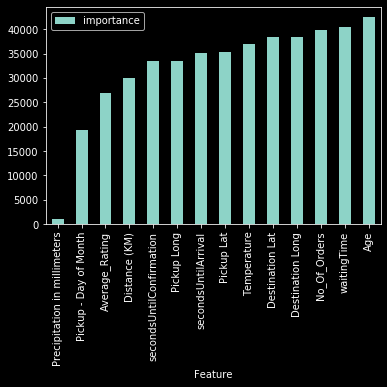

In [48]:
fold_importance_df['importance'] = fold_importance_df.drop(
    'Feature', axis=1).sum(axis = 1)/fold_importance_df.shape[1]
fold_importance_df[['Feature','importance']].sort_values(
    by='importance').plot(x='Feature', y='importance', kind='bar')